In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
import torch
import pandas
import train_model as tm
import my_models as mm
from torchvision import datasets

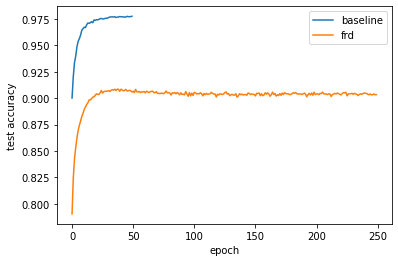

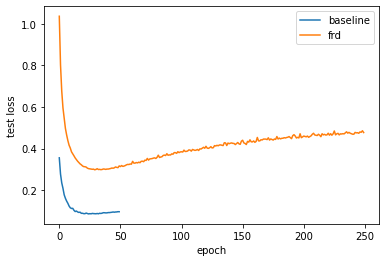

In [2]:
nn_data = pandas.read_csv('/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/training_stats.csv')
frd_data = pandas.read_csv('/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lr_p01/training_stats.csv')
plt.plot(nn_data['Test Accuracy'], label = 'baseline')
plt.plot(frd_data['Test Accuracy'], label = 'frd')
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.show()


plt.figure()
plt.plot(nn_data['Test Loss'], label = 'baseline')
plt.plot(frd_data['Test Loss'], label = 'frd')
plt.legend()
plt.ylabel('test loss')
plt.xlabel('epoch')
plt.show()

In [6]:
def val_rotations(datapath, model_path, data_transforms):
    model = torch.load(model_path)

    return [tm.test_model(datapath+str(d)+'degrees', model, data_transforms) for d in range(0,360,10)]

frd_accs = val_rotations('/data4/mankovic/FRD-NN/FRD_datasets/mnist_splits/', 
                        '/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lr_p01/model/model49.pth',
                        mm.choose_transforms('frd_nn'))
print('frd done')

nn_accs = val_rotations('/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/', 
                        '/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/model/model49.pth',
                        mm.choose_transforms('raw_nn'))


print('nn_done')

frd done
nn_done


Text(0, 0.5, 'Test Accuracy')

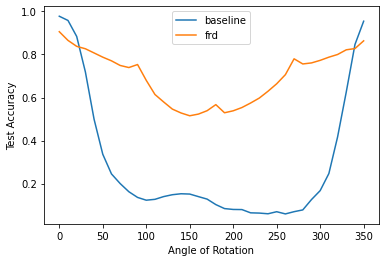

In [7]:
xs = [n for n in range(0,360,10)]


plt.plot(xs, nn_accs, label = 'baseline')
plt.plot(xs, frd_accs, label ='frd')
plt.legend()
plt.xlabel('Angle of Rotation')
plt.ylabel('Test Accuracy')

In [56]:
def feat_space_reps(datapath, transformations, model_path = 'no_model'):
    batch_size = 64
   
    feature_space_reps = torch.tensor([])

    if model_path == 'no_model':
        def my_loader(path):
            return torch.load(path)

        image_dataset = {x: datasets.DatasetFolder(os.path.join(datapath, x), loader = my_loader, transform = transformations[x], extensions = '.pt') for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}


        
        for d,l in dataloaders_dict['test']:
            feature_space_reps = torch.cat([feature_space_reps.float(), d.float()], axis = 0)


    elif 'raw' in model_path:      
        image_dataset = {x: datasets.ImageFolder(os.path.join(datapath, x), transformations[x]) for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}

        model = torch.load(model_path)         
        modules = list(model.children())[:-2]
        encoder = torch.nn.Sequential(*modules)
        
        encoder.float()

        encoder.eval()   # Set model to evaluate mode

        running_corrects = 0


        for inputs, labels in dataloaders_dict['test']:

            with torch.set_grad_enabled(False):

                outputs = encoder(inputs.float())
                feature_space_reps = torch.cat([feature_space_reps, outputs], axis = 0)

    else:      
        def my_loader(path):
            return torch.load(path)

        image_dataset = {x: datasets.DatasetFolder(os.path.join(datapath, x), loader = my_loader, transform = transformations[x], extensions = '.pt') for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}

        model = torch.load(model_path)         
        modules = list(model.children())[:-2]
        encoder = torch.nn.Sequential(*modules)
        
        encoder.float()

        encoder.eval()   # Set model to evaluate mode

        running_corrects = 0


        for inputs, labels in dataloaders_dict['test']:

            with torch.set_grad_enabled(False):

                outputs = encoder(inputs.float())
                feature_space_reps = torch.cat([feature_space_reps, outputs], axis = 0)

    return feature_space_reps

In [57]:
def distances(model_path = 'nothing'):
    diff_stats = {'mean':[], 'std': []}
    if 'raw' in model_path:
        transforms = mm.choose_transforms('raw_nn')
        datapath = '/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, model_path)

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms, model_path)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))

    if 'frd' in model_path:
        transforms = mm.choose_transforms('frd_nn')
        datapath = '/data4/mankovic/FRD-NN/FRD_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, model_path)

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/FRD_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms, model_path)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))
    else:
        transforms = mm.choose_transforms('frd_nn')
        datapath = '/data4/mankovic/FRD-NN/FRD_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, 'no_model')

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/FRD_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))
    return diff_stats

In [60]:
model_path = '/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/model/model49.pth'
raw_stats = distances(model_path)





In [61]:
frd_stats = distances()

KeyboardInterrupt: 

In [ ]:
model_path = '/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lr_p01/model/model49.pth'
frd_nn_stats = distances(model_path)

In [ ]:
plt.plot(raw_stats['mean'], label = 'nn')
plt.plot(frd_stats['mean'], label = 'just frd')
plt.plot(frd_nn_stats['mean'], label = 'frd')
plt.legend()
plt.show()

(tensor(348.3645, dtype=torch.float64), tensor(855.9980, dtype=torch.float64))